In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 13%|███████▊                                                      | 7549/60000 [00:00<00:00, 75485.57it/s]

 25%|███████████████▍                                             | 15163/60000 [00:00<00:00, 75864.18it/s]

 38%|███████████████████████▏                                     | 22750/60000 [00:00<00:00, 71871.04it/s]

 50%|██████████████████████████████▌                              | 30117/60000 [00:00<00:00, 72555.49it/s]

 63%|██████████████████████████████████████▎                      | 37721/60000 [00:00<00:00, 73783.73it/s]

 75%|█████████████████████████████████████████████▊               | 45113/60000 [00:00<00:00, 70647.99it/s]

 87%|█████████████████████████████████████████████████████▏       | 52327/60000 [00:00<00:00, 71116.24it/s]

100%|████████████████████████████████████████████████████████████▉| 59922/60000 [00:00<00:00, 72611.40it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 72437.63it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████▌                  | 7032/10000 [00:00<00:00, 70310.34it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 71365.08it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 7lnc1fg2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/383 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/383 [00:00<02:45,  2.31it/s]

  9%|██████▏                                                              | 34/383 [00:00<00:04, 83.35it/s]

 17%|███████████▉                                                        | 67/383 [00:00<00:02, 147.38it/s]

 26%|█████████████████▍                                                 | 100/383 [00:00<00:01, 196.56it/s]

 35%|███████████████████████▎                                           | 133/383 [00:00<00:01, 233.35it/s]

 43%|█████████████████████████████                                      | 166/383 [00:00<00:00, 260.60it/s]

 52%|██████████████████████████████████▊                                | 199/383 [00:01<00:00, 280.12it/s]

 61%|████████████████████████████████████████▌                          | 232/383 [00:01<00:00, 294.55it/s]

 69%|██████████████████████████████████████████████▎                    | 265/383 [00:01<00:00, 304.52it/s]

 78%|████████████████████████████████████████████████████▏              | 298/383 [00:01<00:00, 310.20it/s]

 86%|█████████████████████████████████████████████████████████▉         | 331/383 [00:01<00:00, 315.59it/s]

 95%|███████████████████████████████████████████████████████████████▋   | 364/383 [00:01<00:00, 319.67it/s]

100%|███████████████████████████████████████████████████████████████████| 383/383 [00:01<00:00, 230.13it/s]

train - OK


  0%|                                                                               | 0/96 [00:00<?, ?it/s]

 12%|████████▋                                                            | 12/96 [00:00<00:00, 117.17it/s]

 47%|████████████████████████████████▎                                    | 45/96 [00:00<00:00, 239.28it/s]

 82%|████████████████████████████████████████████████████████▊            | 79/96 [00:00<00:00, 282.35it/s]

100%|█████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 236.06it/s]

val - OK


  0%|                                                                               | 0/81 [00:00<?, ?it/s]

 15%|██████████▏                                                          | 12/81 [00:00<00:00, 117.55it/s]

 54%|█████████████████████████████████████▍                               | 44/81 [00:00<00:00, 233.69it/s]

 96%|██████████████████████████████████████████████████████████████████▍  | 78/81 [00:00<00:00, 279.21it/s]

100%|█████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 218.29it/s]

test InD - OK


  0%|                                                                              | 0/536 [00:00<?, ?it/s]

  2%|█▍                                                                  | 11/536 [00:00<00:04, 107.00it/s]

  8%|█████▍                                                              | 43/536 [00:00<00:02, 230.01it/s]

 14%|█████████▋                                                          | 76/536 [00:00<00:01, 274.25it/s]

 20%|█████████████▋                                                     | 109/536 [00:00<00:01, 294.33it/s]

 26%|█████████████████▊                                                 | 142/536 [00:00<00:01, 306.54it/s]

 33%|█████████████████████▉                                             | 175/536 [00:00<00:01, 314.36it/s]

 39%|██████████████████████████                                         | 208/536 [00:00<00:01, 318.96it/s]

 45%|██████████████████████████████▏                                    | 241/536 [00:00<00:00, 322.20it/s]

 51%|██████████████████████████████████▎                                | 274/536 [00:00<00:00, 324.28it/s]

 57%|██████████████████████████████████████▍                            | 307/536 [00:01<00:00, 325.99it/s]

 63%|██████████████████████████████████████████▌                        | 340/536 [00:01<00:00, 326.82it/s]

 70%|██████████████████████████████████████████████▋                    | 373/536 [00:01<00:00, 327.39it/s]

 76%|██████████████████████████████████████████████████▊                | 406/536 [00:01<00:00, 328.05it/s]

 82%|███████████████████████████████████████████████████████            | 440/536 [00:01<00:00, 328.99it/s]

 88%|███████████████████████████████████████████████████████████▏       | 473/536 [00:01<00:00, 328.47it/s]

 94%|███████████████████████████████████████████████████████████████▎   | 506/536 [00:01<00:00, 328.89it/s]

100%|███████████████████████████████████████████████████████████████████| 536/536 [00:01<00:00, 305.07it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

 37%|█████████████████████████▏                                          | 37/100 [00:00<00:00, 367.81it/s]

 74%|██████████████████████████████████████████████████▎                 | 74/100 [00:00<00:00, 368.45it/s]

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.10it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(24476, 1, 32, 32) (24476, 1, 32, 32) (24476, 256) (24476, 5) (24476,)
(6120, 1, 32, 32) (6120, 1, 32, 32) (6120, 256) (6120, 5) (6120,)
(5139, 1, 32, 32) (5139, 1, 32, 32) (5139, 256) (5139, 5) (5139,)
(34265, 1, 32, 32) (34265, 1, 32, 32) (34265, 256) (34265, 5) (34265,)
(6400, 1, 32, 32) (6400, 1, 32, 32) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


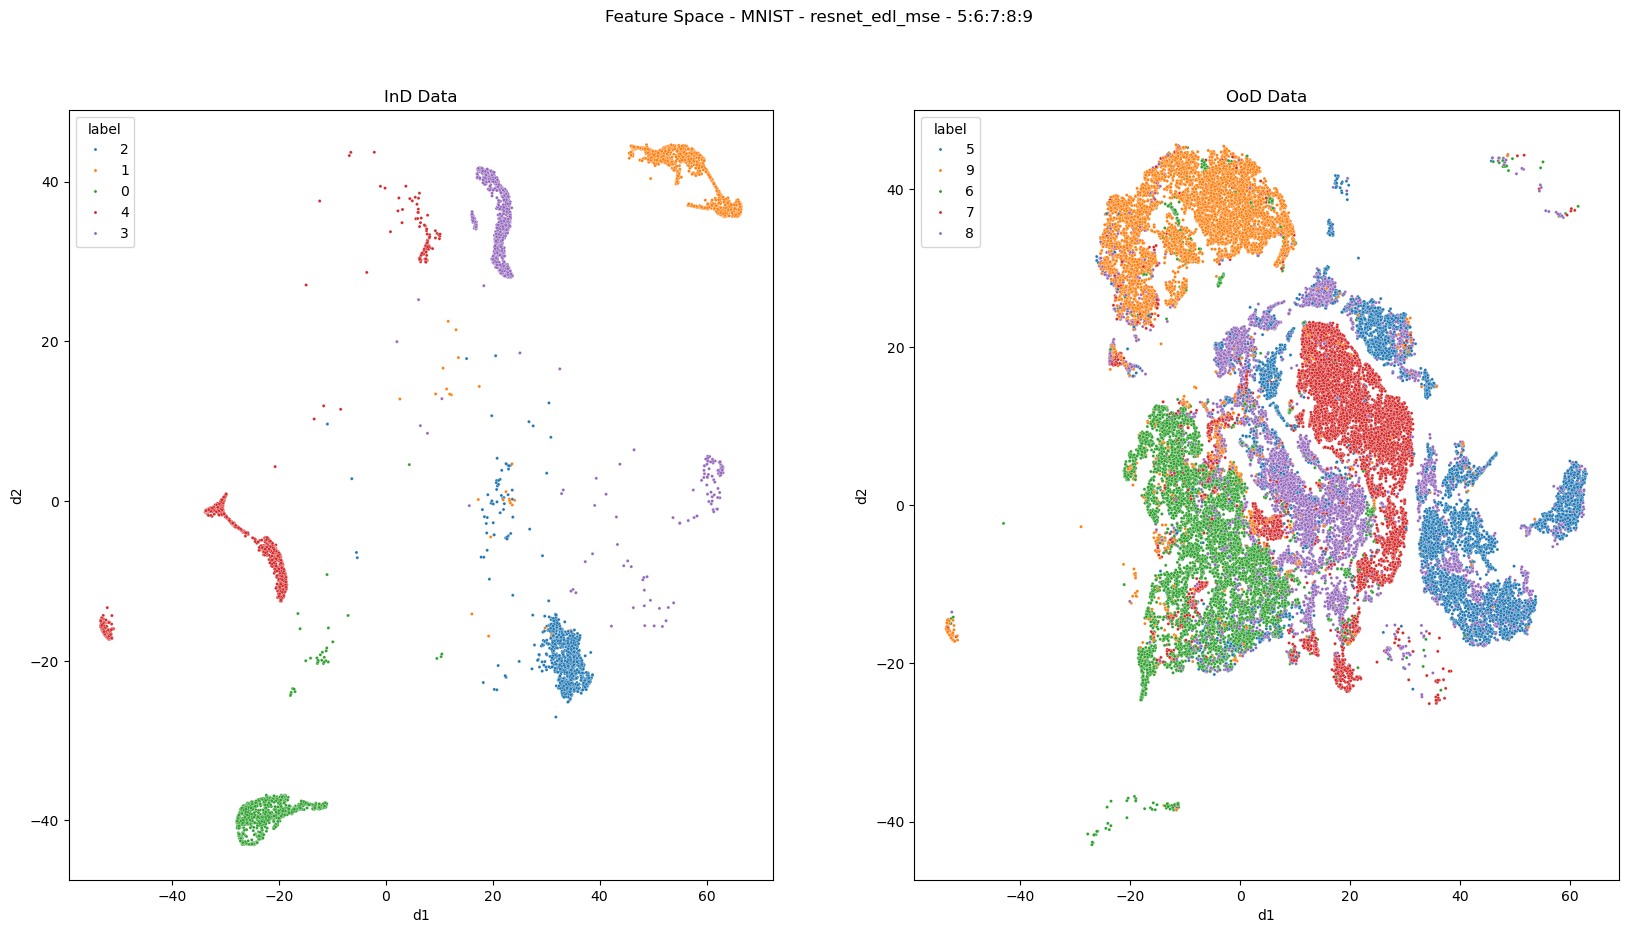

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

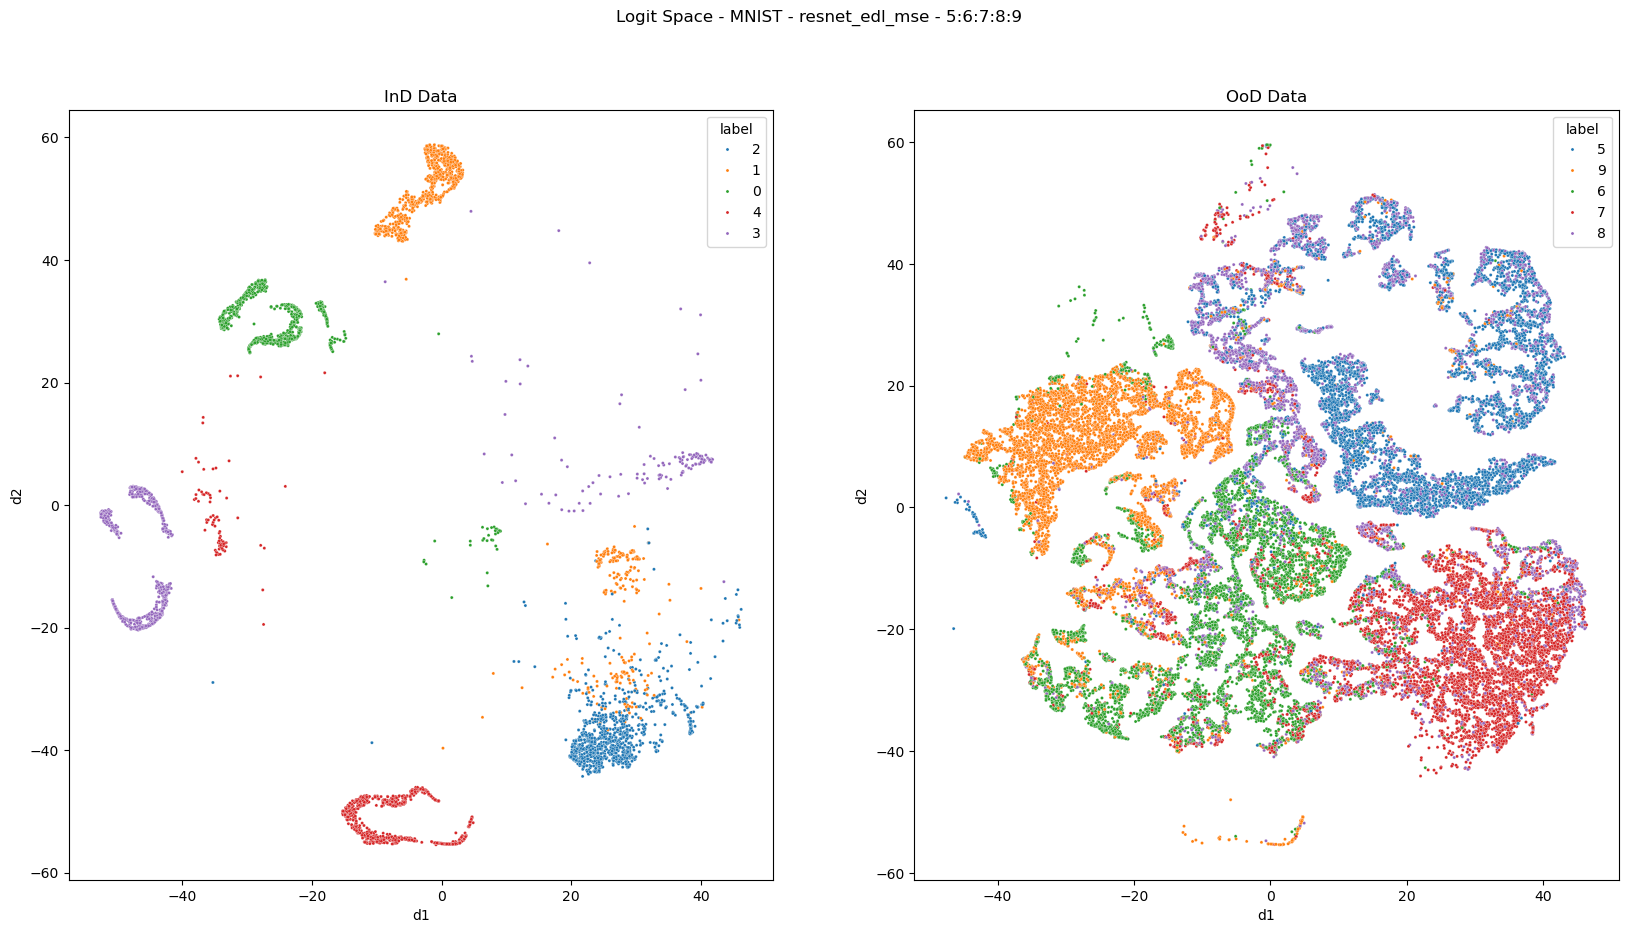

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.07s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.17s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.18s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.26s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it]

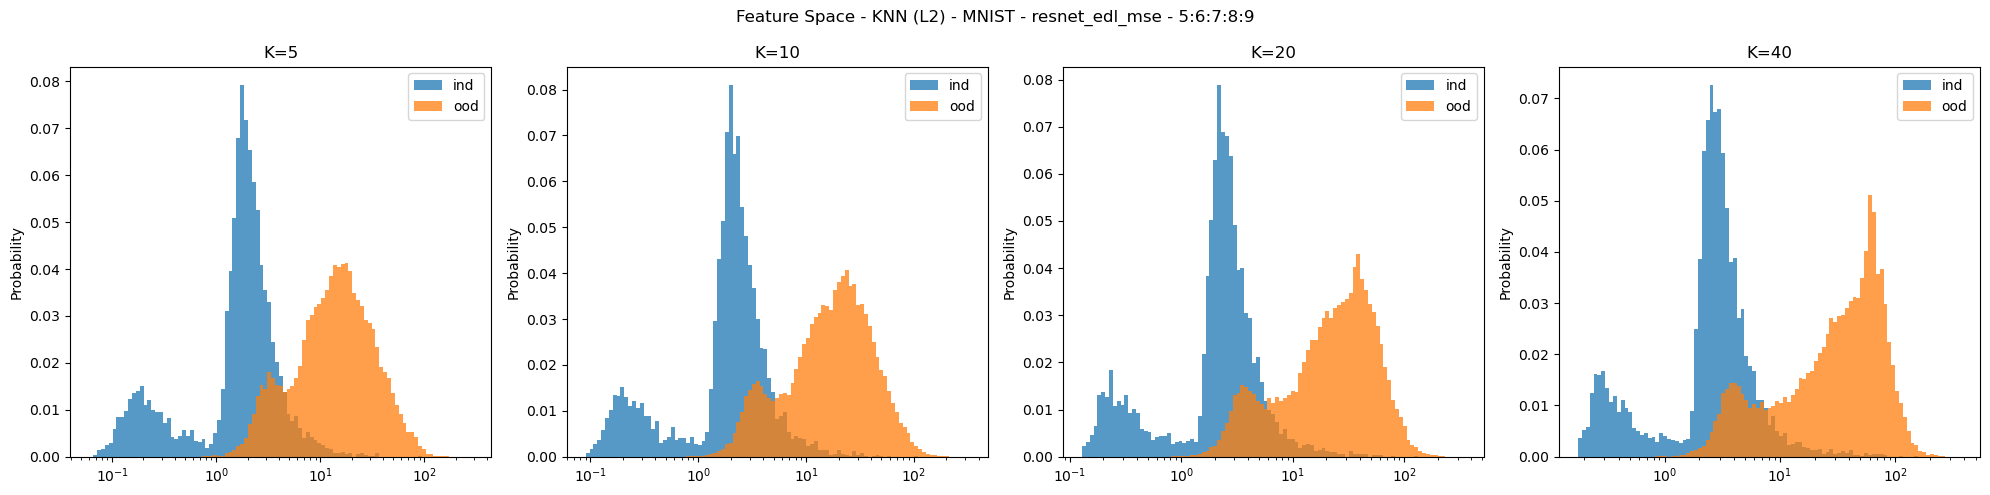

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.02s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.04s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.18s/it]

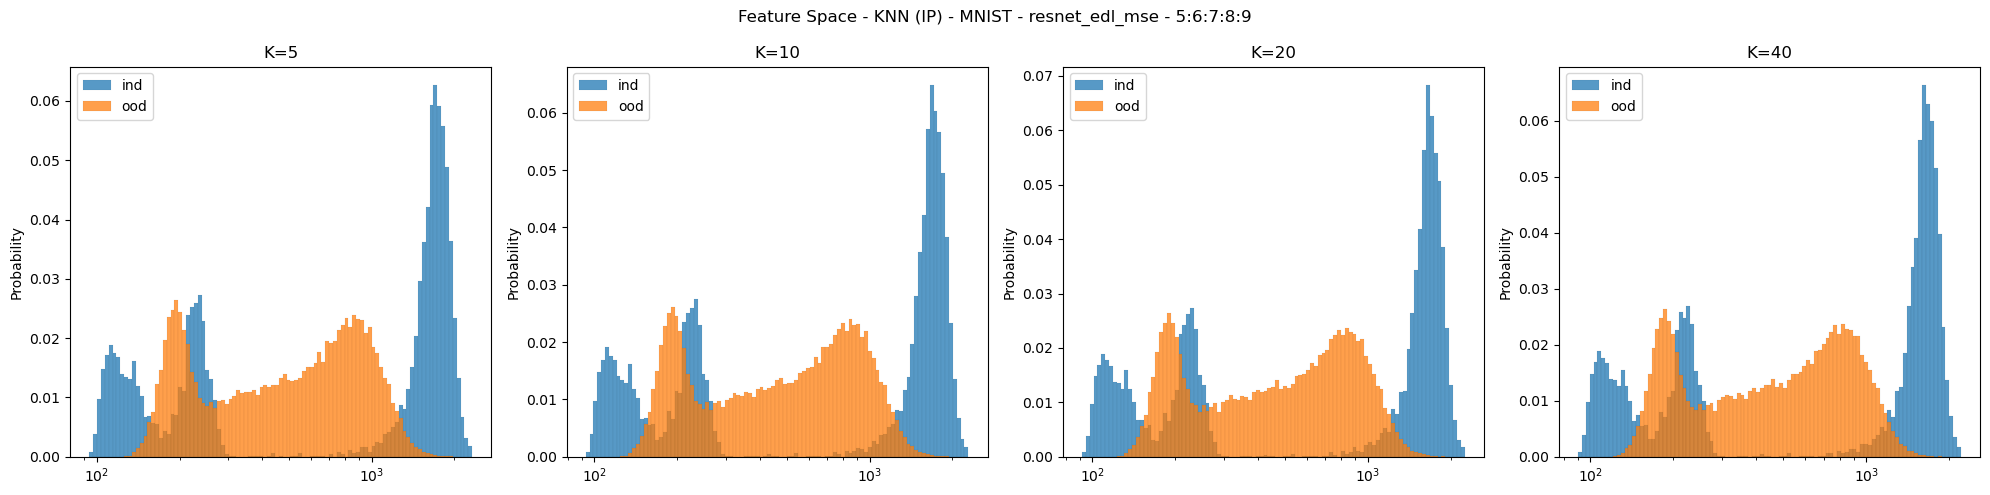

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  2.65it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.51it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.26it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.87it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]

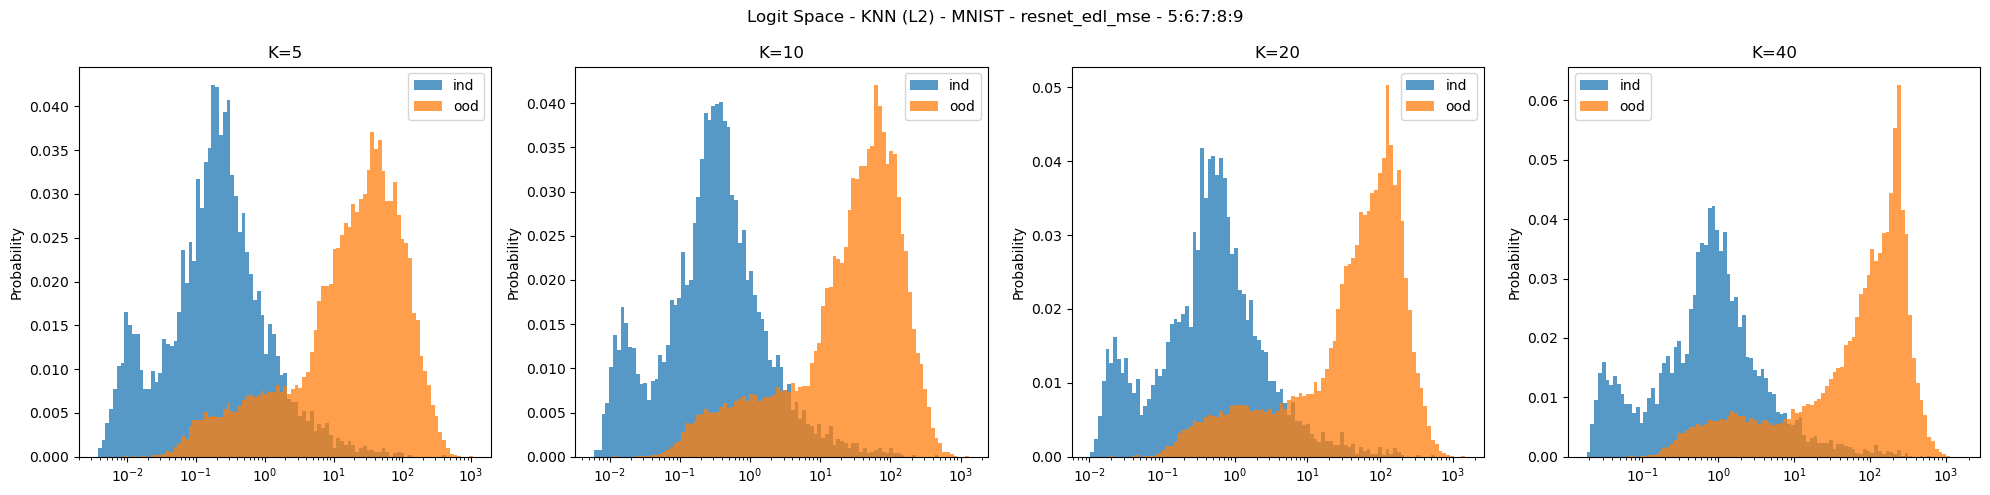

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  1.82it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  2.25it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  2.21it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]

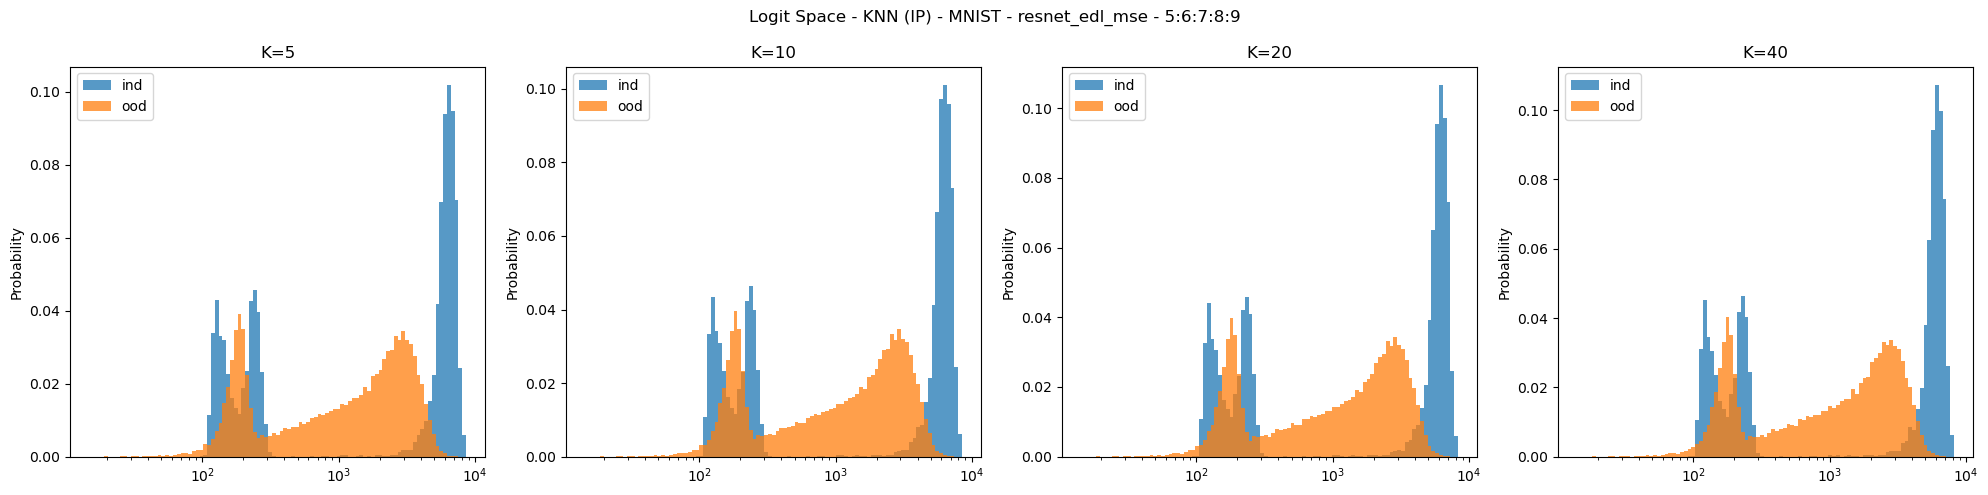

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_763382/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_763382/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)


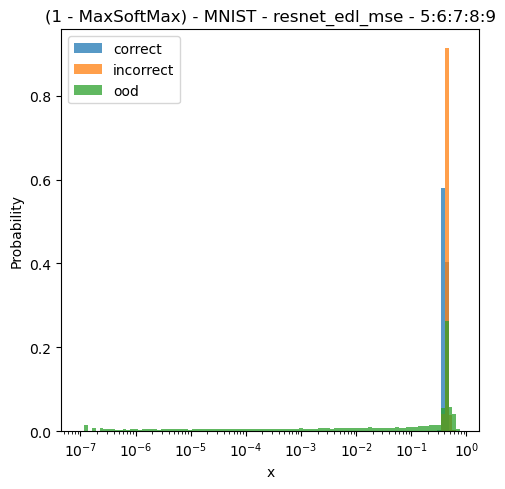

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

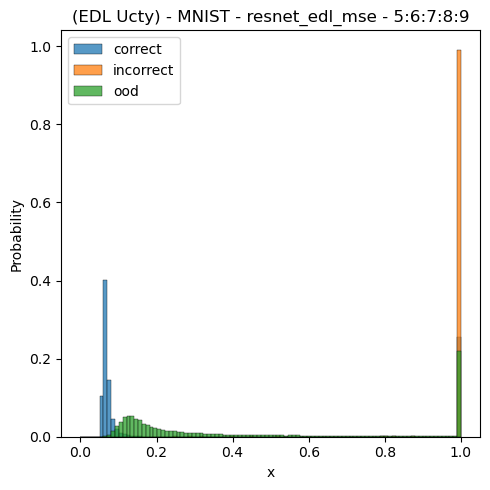

In [20]:
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

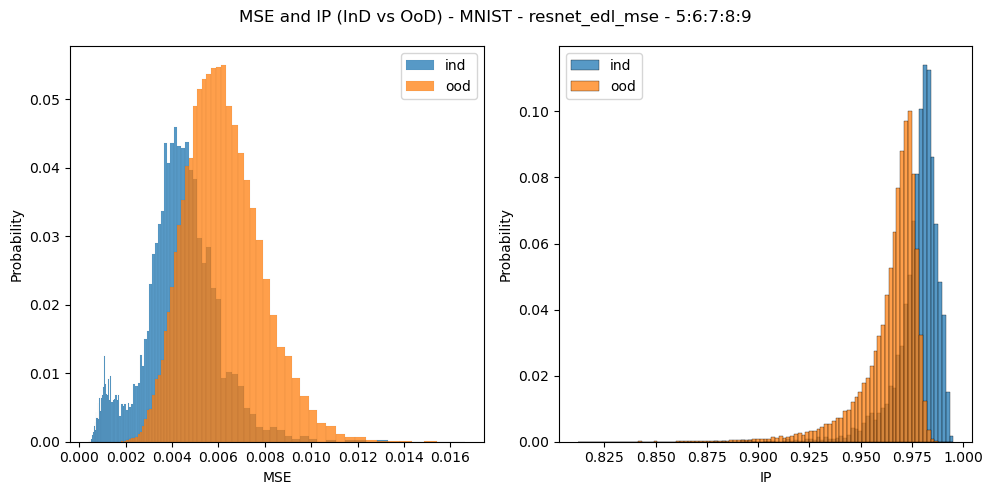

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()